# Application of Random Matrix Theory to Drug Discovery

### Laksh Aithani, University of Cambridge

In [1]:
# Imports
import os

# RDkit, a chemoinformatics library
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Dataset loading functions for ChemBL datasets
def load_dataset(file_name, drop_non_binders = True):
    df = pd.read_csv(file_name, encoding = "ISO-8859-1")
    
    # Converting strings to floats, also set all non-numbers to NaN
    df['Standard Vaue'] = pd.to_numeric(df['Standard Value'],errors = 'coerce')

    # Drop Nans in affinity column
    df.dropna(subset = ['Standard Value'], inplace = True)
    df.reset_index(inplace = True)
    df = df.drop('index',axis = 1)
    
    # Filtering for only activities recorded in nanomolar affinity
    df = df[df['Standard Units'] == 'nM']    

    # Dropping any molecules that don't have a SMILES
    df = df.dropna(subset = ['Canonical Smiles'])
    
    # Considering only the binders (compounds with affinities of less than 1000nM)
    if drop_non_binders:
        df = df[df['Standard Value'] < 1000]
    
    # Dropping duplicate molecules
    df = df.drop_duplicates(subset = 'Canonical Smiles', keep = 'first')
    
    return df

In [4]:
df_train_test = load_dataset(os.path.join(os.getcwd(),'adr1b_chembl.csv'))
df_decoy = load_dataset(os.path.join(os.getcwd(), '5ht1a_chembl.csv'), drop_non_binders = False)

In [5]:
df_train_test.head()

,Molecule,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Comment,Compound Key,Assay,Assay Description,...,Published Units,Canonical Smiles,Data Validity Comment,Document Journal,Document Year,SRC ID,UO Units,Potential Duplicate,Unnamed: 43,Standard Vaue
3,CHEMBL251347,Ki,=,730.00,nM,6.14,NaN,16b,CHEMBL888304,Displacement of [125I]iodocyanopindolol from h...,...,NaN,COc1ccc(cc1)[C@H](CCc2ccccc2)NC[C@H](O)Cc3ccc(...,NaN,Bioorg. Med. Chem. Lett.,2007.0,1,UO_0000065,FALSE,NaN,730.00
5,CHEMBL430390,EC50,=,19.95,nM,7.70,NaN,39,CHEMBL887286,Agonist activity at human beta-1 adrenergic re...,...,NaN,C[C@H](CNc1ccc(cc1)c2nc(cs2)C(=O)O)NC[C@H](O)c...,NaN,Bioorg. Med. Chem. Lett.,2007.0,1,UO_0000065,FALSE,NaN,19.95
9,CHEMBL26917,IC50,=,186.00,nM,6.73,NaN,13,CHEMBL650687,Compound was tested for inhibition of [3H]dihy...,...,NaN,CC(C)NCC(O)COc1ccc(C)c2CCCc12,NaN,J. Med. Chem.,1982.0,1,UO_0000065,FALSE,NaN,186.00
11,CHEMBL39596,Ki,=,310.00,nM,6.51,NaN,5,CHEMBL651835,Ability to bind to human Beta-1 adrenergic rec...,...,NaN,C[C@H](Cc1ccc(OCC(=O)NO)cc1)NC[C@H](O)c2cccc(C...,NaN,Bioorg. Med. Chem. Lett.,1997.0,1,UO_0000065,FALSE,NaN,310.00
14,CHEMBL52407,IC50,=,580.00,nM,6.24,NaN,7c,CHEMBL883288,In vitro binding affinity towards cloned human...,...,NaN,CCCCCCCCc1onc(n1)N2CCc3cc(ccc23)S(=O)(=O)Nc4cc...,NaN,Bioorg. Med. Chem. Lett.,1999.0,1,UO_0000065,FALSE,NaN,580.00


In [6]:
df_decoy.head()

,Molecule,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Comment,Compound Key,Assay,Assay Description,...,Published Value,Published Units,Canonical Smiles,Data Validity Comment,Document Journal,Document Year,SRC ID,UO Units,Potential Duplicate,Standard Vaue
0,CHEMBL27393,Ki,=,11.000,nM,7.96,NaN,23,CHEMBL616058,Binding affinity towards 5-hydroxytryptamine 1...,...,NaN,NaN,O=C(NCCCCN1CCN(CC1)c2ccccc2)c3ccccc3,NaN,J. Med. Chem.,1988.0,1,UO_0000065,True,11.000
1,CHEMBL352029,IC50,=,10.200,nM,7.99,NaN,2,CHEMBL615830,Binding affinity to 5-hydroxytryptamine 1A rec...,...,NaN,NaN,CC1=COc2ccccc2C(=O)N1CCCCN3CCN(CC3)c4ncccn4,NaN,Bioorg. Med. Chem. Lett.,2001.0,1,UO_0000065,False,10.200
2,CHEMBL92630,Ki,=,1600.000,nM,5.80,NaN,5,CHEMBL616310,Tested for affinity against 5-hydroxytryptamin...,...,NaN,NaN,CCCN1CCC[C@H](C1)c2cccc(OS(=O)(=O)c3ccc(C)cc3)c2,NaN,J. Med. Chem.,1994.0,1,UO_0000065,False,1600.000
3,CHEMBL43513,IC50,=,420.000,nM,6.38,NaN,19,CHEMBL615901,Inhibition of [3H]8-OH-DPAT binding at seroton...,...,NaN,NaN,O=C1N(CC#CCN2CCN(CC2)c3nsc4ccccc34)C(=O)c5ccccc15,NaN,J. Med. Chem.,1996.0,1,UO_0000065,False,420.000
4,CHEMBL132657,Ki,=,3.715,nM,8.43,NaN,26,CHEMBL616349,Binding affinity at 5-hydroxytryptamine 1A rec...,...,NaN,NaN,Clc1cccc2C(CCCN3CCN(CC3)c4cccc5OCCOc45)Cc12,NaN,J. Med. Chem.,1995.0,1,UO_0000065,False,3.715


In [7]:
def generate_morgan_matrix(smiles):
    
    # Function that generates the Morgan matrix - can take a couple of minutes
    # for 1000s of molecules
    
    # Input is a pandas Series of SMILES representation of molecules
    
    morgan_matrix = np.zeros((1,2048))
    l = len(smiles)
    
    # Iterate through the compounds
    for i in range(l):
        
        # For each compound, get the structure, convert to Morgan fingerprint,
        # and add to the data matrix
        
        try:
            compound = Chem.MolFromSmiles(smiles[i])
            fp = Chem.AllChem.GetMorganFingerprintAsBitVect(compound, 2, nBits = 2048)
            fp = fp.ToBitString()
            matrix_row = np.array([int(x) for x in list(fp)])
            morgan_matrix = np.row_stack((morgan_matrix, matrix_row))
            
            # Progress checker
            if i%500==0:
                percentage = np.round(100*(i/l),1)
                print(f'{percentage}% done')
        except:
            print(f'problem index:{i}')
    
    # Deleting first row of zeros
    morgan_matrix = np.delete(morgan_matrix, 0, axis = 0)
    
    print('\n')
    print(f'Morgan Matrix dimensions:{morgan_matrix.shape}')
    return morgan_matrix

In [8]:
smiles_train_test = df_train_test['Canonical Smiles']
smiles_train_test = smiles_train_test.reset_index()['Canonical Smiles']
affinity_train_test = df_train_test['Standard Value']

# Making 
binding_threshold = 1000  # units of nM
affinity_train_test = affinity_train_test.apply(lambda x: 0 if x > binding_threshold else 1)

smiles_decoy = df_decoy['Canonical Smiles']
smiles_decoy = smiles_decoy.reset_index()['Canonical Smiles']
affinity_decoy = pd.Series([0 for i in range(len(smiles_decoy))])

In [9]:
Morgan_matrix_train_test = generate_morgan_matrix(smiles_train_test)

0.0% done
56.1% done


Morgan Matrix dimensions:(892, 2048)


In [221]:
Morgan_matrix_decoy = generate_morgan_matrix(smiles_decoy)

0.0% done
12.3% done
24.6% done
36.8% done
49.1% done
61.4% done
73.7% done
86.0% done
98.2% done


Morgan Matrix dimensions:(4072, 2048)


In [222]:
X_train, X_test, y_train, y_test = train_test_split(Morgan_matrix_train_test, affinity_train_test, random_state = 3)

In [223]:
y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [224]:
X_train.shape

(669, 2048)

In [225]:
Morgan_matrix_train_test.shape

(892, 2048)

In [226]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Morgan_matrix_decoy = scaler.transform(Morgan_matrix_decoy)

In [ ]:
# Generate list of the column indices that will be used to delete the columns
cols_to_delete = []
for col_idx in range(X_train.shape[1]):
    if X_train[:,col_idx].std()==0.0:
        cols_to_delete.append(col_idx)

In [ ]:
def delete_columns(matrix, cols_to_delete):
    return np.delete(matrix, cols_to_delete, axis = 1)

In [ ]:
# Delete columns/features in all matrices that have 0 std in the training matrix
X_train = delete_columns(X_train, cols_to_delete)
X_test = delete_columns(X_test, cols_to_delete)
Morgan_matrix_decoy = delete_columns(Morgan_matrix_decoy, cols_to_delete)

In [15]:
def projection(trial_molecule,dim_V, p, feature_vecs):
    trial_molecule_proj = np.zeros(p)
    for idx in range(dim_V):
        dotprod = float(np.vdot(feature_vecs[:,idx], trial_molecule))
        trial_molecule_proj = trial_molecule_proj + dotprod * feature_vecs[:,idx]
    
    return np.array([float(i) for i in trial_molecule_proj])

In [313]:
class RMTClassifier(object):
    
    def __init__(self,threshold_multiple = 1,train_cutoff = 0.95):
        self.thresh_multiple = threshold_multiple
        self.train_cutoff = train_cutoff
        
        self.epsilon = None
        self.feature_vecs = None
        self.dim_V = None
        self.p = None
        
        self.test_set_similarity = None
        
    def fit(self, train_mat):
        
        # This code explains better what is going on
        
        N,p = train_mat.shape
        self.p = p
        # Eigenvalue threshold from Random Matrix Theory
        # https://www.pnas.org/content/113/48/13564#ref-11
        gamma = p/N #Gamma describes how well-sampled the data matrix is
        thresh = ((1 + np.sqrt(gamma))**2)*self.thresh_multiple

        
        # Correlation matrix
        C = np.dot(train_mat.T, train_mat)/N
        
        # Eigenvalues of correlation matrix (think PCA)
        evals, evecs = np.linalg.eig(C)
        idx = evals.argsort()
        idx = idx[::-1]
        evals = evals[idx]
        evecs = evecs[:,idx]
        
        # Find significant feature space V
        dim_V = evals[evals > thresh].shape[0]
        feature_vecs = evecs[:,:dim_V]
        
        self.dim_V, self.feature_vecs = dim_V, feature_vecs
        
        # Project molecules onto V and then compute similarity beween molecules and projection
        similarity = []
        for mol_vec_idx in range(N):
            trial_molecule = train_mat[mol_vec_idx,:]
            trial_molecule_proj = projection(trial_molecule, dim_V, p, feature_vecs)
            similarity.append(np.linalg.norm(trial_molecule-trial_molecule_proj))
            
        # Find cutoff such that 95% (or specified otherwise) of training molecules are classified as binders
        similarity.sort()
        similarity = np.array(similarity)
        cutoff_idx = int(self.train_cutoff * len(similarity))
        epsilon = similarity[cutoff_idx]
        self.epsilon = epsilon
        
    def fit2(self, train_mat):
        
        # This code is optimized for speed using numpy matrix operations
        
        N,p = train_mat.shape
        self.p = p
        # Eigenvalue threshold from Random Matrix Theory
        # https://www.pnas.org/content/113/48/13564#ref-11
        gamma = p/N #Gamma describes how well-sampled the data matrix is
        thresh = ((1 + np.sqrt(gamma))**2)*self.thresh_multiple

        
        # Correlation matrix
        C = np.dot(train_mat.T, train_mat)/N
        
        # Eigenvalues of correlation matrix (think PCA)
        evals, evecs = np.linalg.eig(C)
        idx = evals.argsort()
        idx = idx[::-1]
        evals = evals[idx]
        evecs = evecs[:,idx]
        
        # Find significant feature space V
        dim_V = evals[evals > thresh].shape[0]
        feature_vecs = evecs[:,:dim_V]
        
        self.dim_V, self.feature_vecs = dim_V, feature_vecs
        
        # Project molecules onto V and then compute similarity beween molecules and projection
        similarity = []
        A = np.dot(train_mat, self.feature_vecs)

        for mol_idx in range(N):
            trial_molecule = train_mat[mol_idx,:]
            trial_molecule_proj = np.sum( np.dot( self.feature_vecs, np.diag(A[mol_idx,:])  ) , axis = 1 )
            similarity.append(np.linalg.norm(trial_molecule-trial_molecule_proj))
            
        # Find cutoff such that 95% (or specified otherwise) of training molecules are classified as binders
        similarity.sort()
        similarity = np.array(similarity)
        cutoff_idx = int(self.train_cutoff * len(similarity))
        epsilon = similarity[cutoff_idx]
        self.epsilon = epsilon
    
    def predict(self, test_set, epsilon_multiple = 1):
        # Validation of a test set
        test_set_similarity = []
        for mol_vec_idx in range(test_set.shape[0]):
            trial_molecule = test_set[mol_vec_idx,:]
            trial_molecule_proj = projection(trial_molecule,self.dim_V, self.p, self.feature_vecs)
            test_set_similarity.append( np.linalg.norm( trial_molecule - trial_molecule_proj) )
        
        self.test_set_similarity = test_set_similarity
        
        predictions = np.array([1 if x<self.epsilon*epsilon_multiple else 0 for x in test_set_similarity])
        
        return predictions
    
    def predict2(self, test_set, epsilon_multiple = 1):
        test_set_similarity = []
        
        A = np.dot(test_set,self.feature_vecs)
        
        for mol_idx in range(test_set.shape[0]):
            #trial_molecule = test_set[mol_idx,:]
            trial_molecule_proj = np.sum(  np.dot(self.feature_vecs,np.diag(A[mol_idx,:])),axis = 1)
            test_set_similarity.append(   np.linalg.norm(test_set[mol_idx,:] - trial_molecule_proj))
        
        self.test_set_similarity = test_set_similarity
        
        predictions = np.array([1 if x<self.epsilon*epsilon_multiple else 0 for x in test_set_similarity])
        
        return predictions
    
    def return_indices_of_common_molecules_of_eig(self, matrix, n=5,eigenvector_index=0):
        
        # returns molecules that lie closest to the selected eigenvector
        # default number of molecules returned = 5
        
        # Pick out the (best) eigenvector
        eig = self.feature_vecs[:,eigenvector_index].reshape(clf.p,1)
        
        # Project molecules onto the one-dimensional vector space and get the indices of the top 5 molecules
        # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        return np.argpartition(    np.dot(matrix, eig).reshape(matrix.shape[0])   , -n)[-n:]
        
        


        

In [314]:
# Fit the model
clf = RMTClassifier()
clf.fit2(X_train)

In [315]:
# Predict true positive rate
test_preds = clf.predict2(X_test)
np.mean(test_preds)

0.9237668161434978

In [439]:
# Predict false positive rate
decoy_preds = clf.predict2(Morgan_matrix_decoy)
np.mean(decoy_preds)

0.1662573673870334

[171 472 189 545 466 343 311 242]


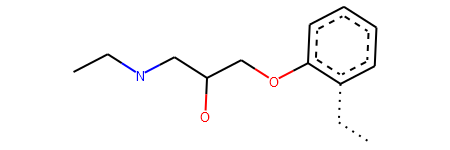

In [440]:
# Code to get pharmacophore of an eigenvector

from rdkit.Chem import rdFMCS

# Specify which eigenvector/pharmacophore you want to find (eigenvector_index)
# Specify the number of molecules to search substructure (n)
idxs = clf.return_indices_of_common_molecules_of_eig(X_train,n=8,eigenvector_index=0)
print(idxs)

df_idxs = y_train.iloc[idxs,:]['index']
smiles_strings = df_train_test.loc[df_idxs]['Canonical Smiles']
mls = [Chem.MolFromSmiles(x) for x in list(smiles_strings)]
res = rdFMCS.FindMCS(mls)
patt = Chem.MolFromSmarts(res.smartsString);patt

In [139]:
clf = RMTClassifier()
clf.fit(X_train)
test_preds = clf.predict(X_test)
decoy_preds = clf.predict(Morgan_matrix_decoy)
np.mean(test_preds),np.mean(decoy_preds)

(0.9147982062780269, 0.0)

In [ ]:
test_preds = clf.predict(X_test, epsilon_multiple = 0.9)
np.mean(test_preds)

In [138]:
test_preds = clf.predict(X_test, epsilon_multiple = 0.9)
decoy_preds = clf.predict(Morgan_matrix_decoy, epsilon_multiple = 0.9)
np.mean(test_preds),np.mean(decoy_preds)

(1.0, 0.08644400785854617)

In [18]:
def false_positive_true_positive(clf,multiple):
    # Must be a fitted classifier
    test_preds = clf.predict2(X_test,epsilon_multiple = multiple)
    decoy_preds = clf.predict2(Morgan_matrix_decoy, epsilon_multiple = multiple)
    tp = np.mean(test_preds)
    fp = np.mean(decoy_preds)
    return fp, tp

In [ ]:
# Plot ROC Curve
x,y = [],[]
for idx,val in enumerate(np.linspace(0.4,2,25)):
    
    # Progress checker
    if idx%3==0:
        print(f'progress:{(idx+1)*4}%')
    fp, tp = false_positive_true_positive(clf,val)
    x.append(fp)
    y.append(tp)

In [ ]:
AUC = sklearn.metrics.auc(x, y)
AUC = round(AUC,2); AUC

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.set_xlabel('False positive')
ax.set_ylabel('True positive')
ax.text(0.76,0.15, f'AUC:{str(AUC)}', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
ax.plot(x, y)
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--')
ax.axis([0, 1, 0, 1])
plt.show()
fig.savefig("ROC_Curve.png",dpi = 1000)